# KI in den Geschichtswissenschaften
Ein Vortrag des Historischen Seminars der Leibniz Universität Hannover an der GWLB am 10.02.2026.


In [5]:
%pip install graphviz
%pip install matplotlib
%pip install numpy
import matplotlib.pyplot as plt
import numpy as np

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


---

## Markov-Ketten

### Einführung

Eine Markov-Kette ist ein mathematisches Modell zur Beschreibung von stochastischen Prozessen, bei denen die Zukunft nur vom gegenwärtigen Zustand abhängt, nicht von der Vergangenheit. Diese Eigenschaft wird als **Markov-Eigenschaft** oder **Gedächtnislosigkeit** bezeichnet.

#### Formale Definition

Eine Markov-Kette ist ein diskreter stochastischer Prozess ${X_n : n \in \mathbb{N}}$, der die folgende Bedingung erfüllt:

$$P(X_{n+1}) = (P(X_{n+1} = j | X_n = i)$$

Dies bedeutet, dass die Wahrscheinlichkeit des nächsten Zustands nur vom aktuellen Zustand abhängt.

### Beispiel zur Markov-Eigenschaft: Wettermodell

Stellen wir uns ein einfaches Wettermodell mit drei Zuständen vor: **Sonnig (S)**, **Bewölkt (B)**, **Regnerisch (R)**.

Die Markov-Eigenschaft besagt: *Die Wahrscheinlichkeit, dass es morgen regnet, hängt nur davon ab, wie das Wetter heute ist – nicht davon, wie das Wetter in der letzten Woche war.*

**Beispiel:**
- Wenn heute Sonnig ist, ist die Wahrscheinlichkeit für Regen morgen: $P(\text{Morgen} = R | \text{Heute} = S) = 0.1$
- Diese Wahrscheinlichkeit bleibt gleich, egal ob es:
  - Die letzten 10 Tage sonnig war, oder
  - Die letzten 10 Tage regnerisch war
  
Das ist die **Gedächtnislosigkeit**: Der Prozess "erinnert sich" nicht an die Vergangenheit!

Mathematisch ausgedrückt:
$$P(\text{Morgen} = R | \text{Heute} = S, \text{Gestern} = S, \text{Vorgestern} = S, ...) = P(\text{Morgen} = R | \text{Heute} = S) = 0.1$$

Die zusätzliche Information über die Vergangenheit ändert die Wahrscheinlichkeit nicht.

#### Übergangswahrscheinlichkeiten

Die Übergangswahrscheinlichkeiten einer Markov-Kette werden in der **Übergangsmatrix** \(P\) zusammengefasst:

Für jede Zeile gilt außerdem, dass die Summe aller Wahrscheinlichkeiten gleich 1 ist:

$
\sum_{j=1}^{n} p_{ij} = 1 \qquad \text{für alle } i \in \{1, \dots, n\}.
$


**Beispiel für das Wettermodell:**

$$P = \begin{pmatrix} 0.7 & 0.2 & 0.1 \\ 0.3 & 0.4 & 0.3 \\ 0.2 & 0.3 & 0.5 \end{pmatrix}$$

Dabei bedeutet:
- Zeile 1 (Sonnig): Mit 70% bleibt es sonnig, mit 20% wird es bewölkt, mit 10% regnet es
- Zeile 2 (Bewölkt): Mit 30% wird es sonnig, mit 40% bleibt es bewölkt, mit 30% regnet es
- Zeile 3 (Regnerisch): Mit 20% wird es sonnig, mit 30% wird es bewölkt, mit 50% bleibt es regnerisch


#### Eigenschaften

- **Endliche Zustandsräume**: Meist wird mit einer endlichen Menge von Zuständen gearbeitet
- **Homogenität**: Die Übergangswahrscheinlichkeiten sind zeitunabhängig
- **Normalität**: Die Summe der Übergangswahrscheinlichkeiten in jeder Zeile ist 1 


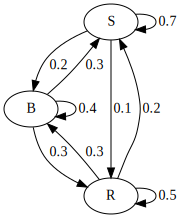

In [6]:
from graphviz import Digraph

dot = Digraph()

# Nodes
dot.node('S', 'S')
dot.node('B', 'B')
dot.node('R', 'R')

# Edges from S (row 1)
dot.edge('S', 'S', label='0.7')
dot.edge('S', 'B', label='0.2')
dot.edge('S', 'R', label='0.1')

# Edges from B (row 2)
dot.edge('B', 'S', label='0.3')
dot.edge('B', 'B', label='0.4')
dot.edge('B', 'R', label='0.3')

# Edges from R (row 3)
dot.edge('R', 'S', label='0.2')
dot.edge('R', 'B', label='0.3')
dot.edge('R', 'R', label='0.5')

dot

Eine Markov-Kette "erinnert" sich nur an den letzten Zustand. Soll bedeuten, die Wahl des nächsten Zustands hängt vom aktuellen Zustand ab. Bezogen auf natürliche Sprache bedeutet dies, das nächste Wort wird abhängig vom aktuellem gewählt, ergo ohne breiteren Kontext des Satzes. Zusätzlich muss alles was in einem Computer vorgeht durch Nummern repräsentiert werden. **Ein Computer kennt die Semantik eines Wortes nicht.**

---

# Word Embedding

Worteinbettungen sind eine Möglichkeit, Wörter als Vektoren in einem mehrdimensionalen Raum darzustellen, wobei der Abstand und die Richtung zwischen den Vektoren die Ähnlichkeit und Beziehungen zwischen den entsprechenden Wörtern widerspiegeln.

## Vektoren

Das Hauptziel von Worteinbettungen ist es, Wörter so darzustellen, dass ihre semantischen Beziehungen und Kontextinformationen erfasst werden. Diese Vektoren sind numerische Darstellungen in einem kontinuierlichen Vektorraum, wobei die relativen Positionen der Vektoren die semantischen Ähnlichkeiten und Beziehungen zwischen den Wörtern widerspiegeln.

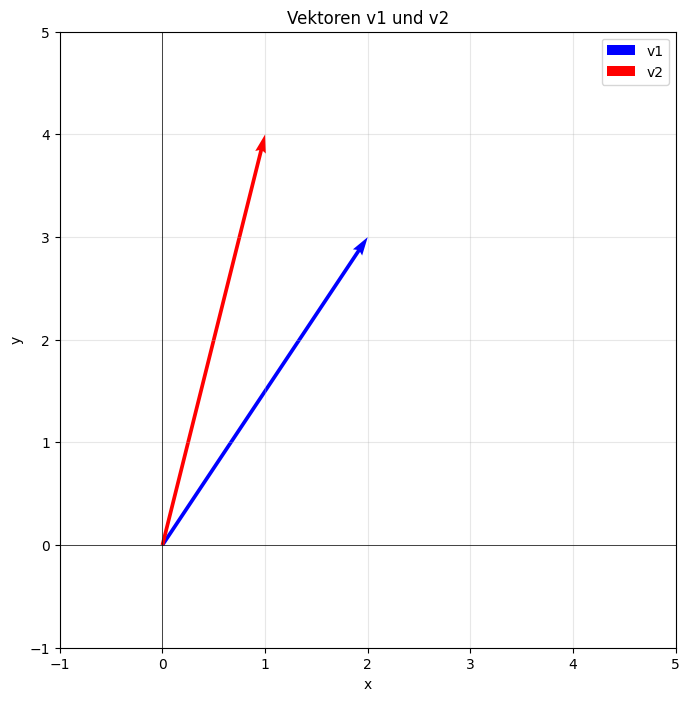

In [22]:
# Visualisierung der Vektoren
fig, ax = plt.subplots(figsize=(8, 8))

v1 = np.array([2, 3])
v2 = np.array([1, 4])

# Vektoren zeichnen
ax.quiver(
    0,
    0,
    v1[0],
    v1[1],
    angles="xy",
    scale_units="xy",
    scale=1,
    color="blue",
    width=0.006,
    label="v1",
)
ax.quiver(
    0,
    0,
    v2[0],
    v2[1],
    angles="xy",
    scale_units="xy",
    scale=1,
    color="red",
    width=0.006,
    label="v2",
)


# Achsen einstellen
ax.set_xlim(-1, 5)
ax.set_ylim(-1, 5)
ax.set_aspect("equal")
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color="k", linewidth=0.5)
ax.axvline(x=0, color="k", linewidth=0.5)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Vektoren v1 und v2")
ax.legend()

plt.show()

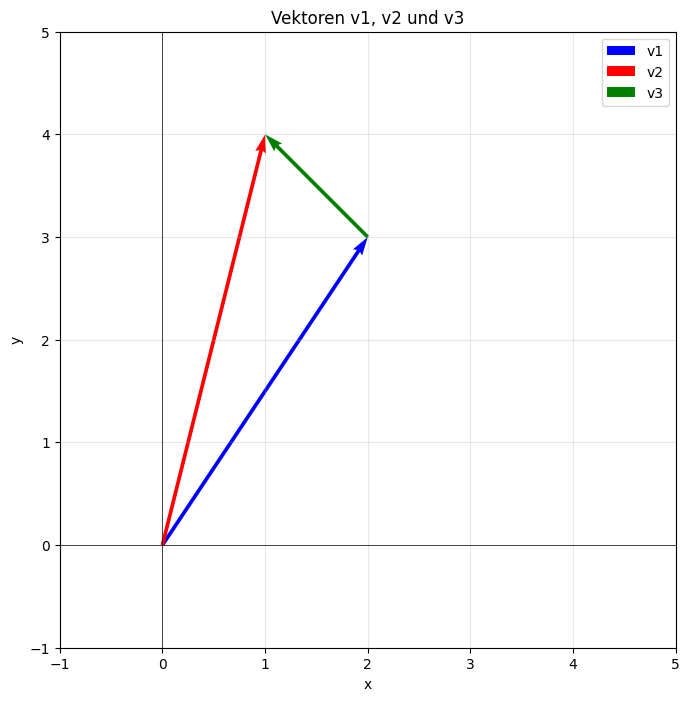

In [24]:
# Visualisierung der Vektoren
fig, ax = plt.subplots(figsize=(8, 8))

v1 = np.array([2, 3])
v2 = np.array([1, 4])

# v1
ax.quiver(
    0,
    0,
    v1[0],
    v1[1],
    angles="xy",
    scale_units="xy",
    scale=1,
    color="blue",
    width=0.006,
    label="v1",
)

# v2
ax.quiver(
    0,
    0,
    v2[0],
    v2[1],
    angles="xy",
    scale_units="xy",
    scale=1,
    color="red",
    width=0.006,
    label="v2",
)

# Verbindungsvektor von v1 nach v2
v3 = v2 - v1
ax.quiver(
    v1[0],
    v1[1],
    v3[0],
    v3[1],
    angles="xy",
    scale_units="xy",
    scale=1,
    color="green",
    width=0.006,
    label="v3",
)


# Achsen einstellen
ax.set_xlim(-1, 5)
ax.set_ylim(-1, 5)
ax.set_aspect("equal")
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color="k", linewidth=0.5)
ax.axvline(x=0, color="k", linewidth=0.5)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Vektoren v1, v2 und v3")
ax.legend()

plt.show()